<a href="https://colab.research.google.com/github/hiyori99/Colaboratory/blob/main/association2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#データセットの読み込み
import urllib.request
from io import StringIO

url = "https://raw.githubusercontent.com/tachiken0210/dataset/master/dataset_cart.csv"

#csvを読み込む関数
def read_csv(url):
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO( res) )
    return df

#実行
df_cart_ori = read_csv(url)

In [3]:
df_cart_ori.head()

,cart_id,goods_id,action,create_at,update_at,last_update,time
0,108750017,583266,UPD,2013-11-26 03:11:06,2013-11-26 03:11:06,2013-11-26 03:11:06,1385478215
1,108750017,662680,UPD,2013-11-26 03:11:06,2013-11-26 03:11:06,2013-11-26 03:11:06,1385478215
2,108750017,664077,UPD,2013-11-26 03:11:06,2013-11-26 03:11:06,2013-11-26 03:11:06,1385478215
3,108199875,661648,ADD,2013-11-26 03:11:10,2013-11-26 03:11:10,2013-11-26 03:11:10,1385478215
4,105031004,661231,ADD,2013-11-26 03:11:41,2013-11-26 03:11:41,2013-11-26 03:11:41,1385478215


In [4]:
df_cart_ori["cart_id"].value_counts().head()

110728794    475
106932411    426
115973611    264
109269739    205
112332751    197
Name: cart_id, dtype: int64

In [5]:
df_cart_ori[df_cart_ori["cart_id"]==110728794].head(10)

,cart_id,goods_id,action,create_at,update_at,last_update,time
32580,110728794,664457,ADD,2013-11-26 22:54:13,2013-11-26 22:54:13,2013-11-26 22:54:13,1385478215
32619,110728794,664885,ADD,2013-11-26 22:55:09,2013-11-26 22:55:09,2013-11-26 22:55:09,1385478215
33047,110728794,664937,ADD,2013-11-26 22:58:52,2013-11-26 22:58:52,2013-11-26 22:58:52,1385478215
33095,110728794,664701,ADD,2013-11-26 23:00:25,2013-11-26 23:00:25,2013-11-26 23:00:25,1385478215
34367,110728794,665050,ADD,2013-11-26 23:02:40,2013-11-26 23:02:40,2013-11-26 23:02:40,1385478215
34456,110728794,664989,ADD,2013-11-26 23:05:03,2013-11-26 23:05:03,2013-11-26 23:05:03,1385478215
34653,110728794,664995,ADD,2013-11-26 23:07:00,2013-11-26 23:07:00,2013-11-26 23:07:00,1385478215
34741,110728794,664961,ADD,2013-11-26 23:09:41,2013-11-26 23:09:41,2013-11-26 23:09:41,1385478215
296473,110728794,665412,DEL,2013-12-03 17:17:30,2013-12-03 17:17:30,2013-12-03 07:41:13,1386083014
296476,110728794,665480,DEL,2013-12-03 17:17:37,2013-12-03 17:17:37,2013-12-03 07:42:29,1386083014


In [6]:
df = df_cart_ori.copy()
df = df[df["action"]=="ADD"]
df.head()

,cart_id,goods_id,action,create_at,update_at,last_update,time
3,108199875,661648,ADD,2013-11-26 03:11:10,2013-11-26 03:11:10,2013-11-26 03:11:10,1385478215
4,105031004,661231,ADD,2013-11-26 03:11:41,2013-11-26 03:11:41,2013-11-26 03:11:41,1385478215
6,110388732,661534,ADD,2013-11-26 03:11:55,2013-11-26 03:11:55,2013-11-26 03:11:55,1385478215
7,110388740,662336,ADD,2013-11-26 03:11:58,2013-11-26 03:11:58,2013-11-26 03:11:58,1385478215
8,110293997,661648,ADD,2013-11-26 03:12:13,2013-11-26 03:12:13,2013-11-26 03:12:13,1385478215


In [7]:
df = df[["cart_id","goods_id","create_at"]]
df = df.sort_values(["cart_id","create_at"],ascending=[True,True])
df.head()

,cart_id,goods_id,create_at
548166,78496306,661142,2013-11-15 23:07:02
517601,79100564,662760,2013-11-24 18:17:24
517404,79100564,661093,2013-11-24 18:25:29
23762,79100564,664856,2013-11-26 13:41:47
22308,79100564,562296,2013-11-26 13:44:20


In [8]:
df = df[["cart_id","goods_id"]]
df["goods_id"] = df["goods_id"].astype(int).astype(str)
df = df.groupby(["cart_id"])["goods_id"].apply(lambda x:list(x)).reset_index()
df.head()

,cart_id,goods_id
0,78496306,[661142]
1,79100564,"[662760, 661093, 664856, 562296, 663364, 66496..."
2,79455669,"[663801, 664136, 664937, 663932, 538673, 66390..."
3,81390353,"[663132, 661725, 664236, 663331, 659679, 66384..."
4,81932021,"[662282, 664218]"


In [9]:
def get_combination(l):
    length = len(l)
    list_output = []
    list_pair = []
    for i in range(length-1):
        if l[i]==l[i+1]:
            pass
        else:
            list_pair =[l[i],l[i+1]]
            list_output.append(list_pair)
    return list_output

df["comb_goods_id"] = df["goods_id"].apply(lambda x:get_combination(x))

#アソシエーション入力のリストを作る
dataset= []
for i,contents in enumerate(df["comb_goods_id"].values):
    for c in contents:
        dataset.append(c)

print("XYのペアの数は",len(dataset))
print("XYのペアの中身",dataset[:5])

XYのペアの数は 141956
XYのペアの中身 [['662760', '661093'], ['661093', '664856'], ['664856', '562296'], ['562296', '663364'], ['663364', '664963']]


In [10]:
#アソシエーションライブラリ
def association(dataset):
    df = pd.DataFrame(dataset,columns=["x","y"])
    num_dataset = df.shape[0]
    df["sum_count_xy"]=1
    print("calculating support....")
    df_a_support = (df.groupby("x").sum()/num_dataset).rename(columns={"sum_count_xy":"support_x"})
    df_b_support = (df.groupby("y").sum()/num_dataset).rename(columns={"sum_count_xy":"support_y"})
    df = df.groupby(["x","y"]).sum()
    df["support_xy"]=df["sum_count_xy"]/num_dataset
    df = df.reset_index()
    df = pd.merge(df,df_a_support,on="x")
    df = pd.merge(df,df_b_support,on="y")
    print("calculating confidence....")
    df_temp = df.groupby("x").sum()[["sum_count_xy"]].rename(columns={"sum_count_xy":"sum_count_x"})
    df = pd.merge(df,df_temp,on="x")
    df_temp = df.groupby("y").sum()[["sum_count_xy"]].rename(columns={"sum_count_xy":"sum_count_y"})
    df = pd.merge(df,df_temp,on="y")
    df["confidence"]=df["sum_count_xy"]/df["sum_count_x"]
    print("calculating lift....")
    df["lift"]=df["confidence"]/df["support_y"]
    df["sum_count"] = num_dataset
    df_output = df
    return df_output

In [11]:
#データセットをアソシエーション分析にかける
df_output = association(dataset)
df_output.head()

calculating support....
calculating confidence....
calculating lift....


,x,y,sum_count_xy,support_xy,support_x,support_y,sum_count_x,sum_count_y,confidence,lift,sum_count
0,485836,662615,1,0.000007,0.000007,0.000148,1,21,1.000000,6759.809524,141956
1,549376,662615,1,0.000007,0.000021,0.000148,3,21,0.333333,2253.269841,141956
2,654700,662615,1,0.000007,0.000465,0.000148,66,21,0.015152,102.421356,141956
3,661475,662615,1,0.000007,0.000965,0.000148,137,21,0.007299,49.341675,141956
4,661558,662615,1,0.000007,0.000409,0.000148,58,21,0.017241,116.548440,141956


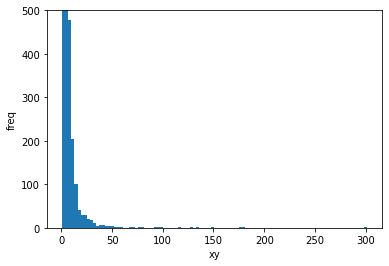

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_output["sum_count_xy"], bins=100)
ax.set_title('')
ax.set_xlabel('xy')
ax.set_ylabel('freq')
#見辛いのでy軸の範囲を限定します
ax.set_ylim(0,500)
fig.show()

In [13]:
df = df_output.copy()
df = df[df["support_xy"]>=df["support_xy"].quantile(0.98)]
df.head()

,x,y,sum_count_xy,support_xy,support_x,support_y,sum_count_x,sum_count_y,confidence,lift,sum_count
58,662193,667129,8,0.000056,0.003614,0.002811,513,399,0.015595,5.548218,141956
59,665672,667129,12,0.000085,0.003952,0.002811,561,399,0.021390,7.610256,141956
60,666435,667129,30,0.000211,0.008228,0.002811,1168,399,0.025685,9.138171,141956
62,666590,667129,7,0.000049,0.004213,0.002811,598,399,0.011706,4.164642,141956
63,666856,667129,8,0.000056,0.003910,0.002811,555,399,0.014414,5.128352,141956


In [14]:
df = df[df["lift"]>=2.0]
df_recommendation = df.copy()
df_recommendation.head()

,x,y,sum_count_xy,support_xy,support_x,support_y,sum_count_x,sum_count_y,confidence,lift,sum_count
58,662193,667129,8,0.000056,0.003614,0.002811,513,399,0.015595,5.548218,141956
59,665672,667129,12,0.000085,0.003952,0.002811,561,399,0.021390,7.610256,141956
60,666435,667129,30,0.000211,0.008228,0.002811,1168,399,0.025685,9.138171,141956
62,666590,667129,7,0.000049,0.004213,0.002811,598,399,0.011706,4.164642,141956
63,666856,667129,8,0.000056,0.003910,0.002811,555,399,0.014414,5.128352,141956


In [15]:
# xは元データのgoods_idなので、それのユニーク数を集計します。
df_cart_ori["goods_id"].nunique()

8398

In [16]:
# レコメンデーション結果のxのユニーク数を集計します。
df_recommendation["x"].nunique()

463